In [1]:
import numpy as np
import pandas as pd
from bisect import bisect_left
import os
from framefinder import framedimensions
from framefinder import framelabels
from scipy.stats import norm

In [ ]:
base_model = "all-mpnet-base-v2"
dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"),
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]
candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
    "Other: any coherent group of frames not covered by the above categories",
]

framing_labels = framelabels.FramingLabels("facebook/bart-large-mnli", candidate_labels)
framing_dimensions = framedimensions.FramingDimensions(
    base_model, dimensions, pole_names
)


In [3]:
def merge_csvs(directory):
    assert(os.path.exists(directory))
    files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    assert(files)

    dfs = []
    for file in files:
        file_path = os.path.join(directory, file)
        dfs.append(pd.read_csv(file_path, header=[0, 1]))
    return pd.concat(dfs, axis=0)


def create_histogram(df, thresholds="auto"):
    histogram_df = pd.DataFrame()

    for col in df.columns:  # for each frame dimension
        hist, bin_edges = np.histogram(df[col], bins=thresholds)
        bin_labels = [
            f"{col}_bin_{round(thresholds[i], 2)}" for i in range(1, len(bin_edges))
        ]

        for label, count in zip(bin_labels, hist):
            histogram_df[label] = [count]

    return histogram_df

In [4]:
def calculate_percentile_normal(x, mean, std):
    return norm.cdf(x, mean, std) * 100

def prepare_and_sort_data(df):
    sorted_data = {col: np.sort(df[col].values) for col in df.columns}
    return pd.DataFrame(sorted_data)

def calculate_percentile_empirically(sorted_df, sample_row):
    percentiles = []
    n_samples = len(sorted_df)
    
    for column in sorted_df.columns:
        sorted_column = sorted_df[column].values
        sample_value = sample_row[column]
        closest_index = bisect_left(sorted_column, sample_value)
        
        if closest_index >= n_samples:
            closest_index = n_samples - 1
        elif closest_index > 0 and abs(sorted_column[closest_index - 1] - sample_value) < abs(sorted_column[closest_index] - sample_value):
            closest_index -= 1
        
        percentiles.append(100 * (closest_index / n_samples))
        
    return percentiles

In [5]:
df = merge_csvs("COP/dumps/cluster/dimensions/by_year")
means = df.mean()
stds = df.std()

for col in df.columns:
    print(f"Dimension: {col}")
    print(f"\tMean {round(means[col], 2)}")
    print(f"\tStandard Deviation {round(stds[col], 2)}")

Dimension: ('Care', 'Harm')
	Mean 0.0
	Standard Deviation 0.07
Dimension: ('Fairness', 'Cheating')
	Mean 0.03
	Standard Deviation 0.07
Dimension: ('Loyalty', 'Betrayal')
	Mean 0.02
	Standard Deviation 0.07
Dimension: ('Authority', 'Subversion')
	Mean -0.0
	Standard Deviation 0.08
Dimension: ('Sanctity', 'Degredation')
	Mean -0.02
	Standard Deviation 0.08


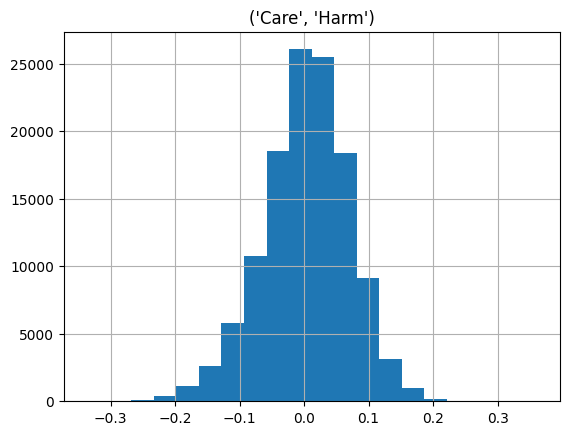

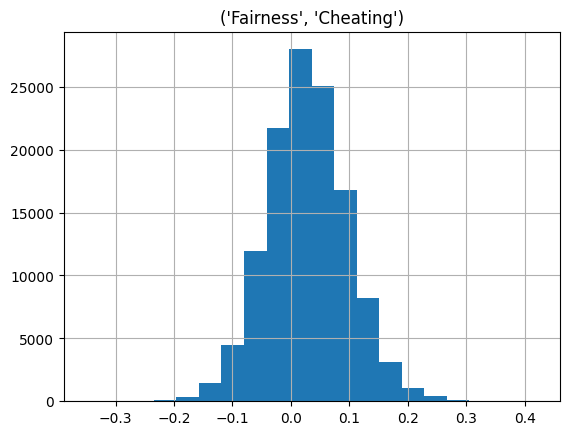

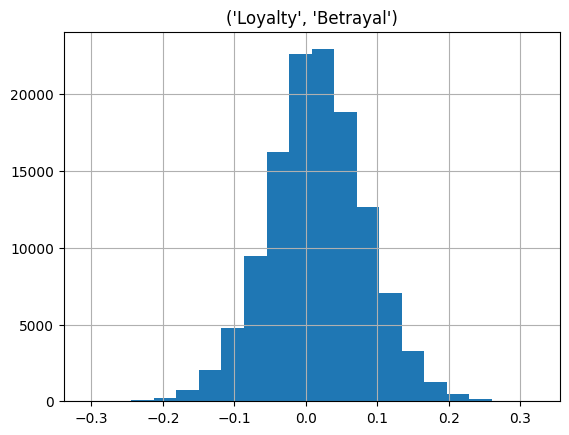

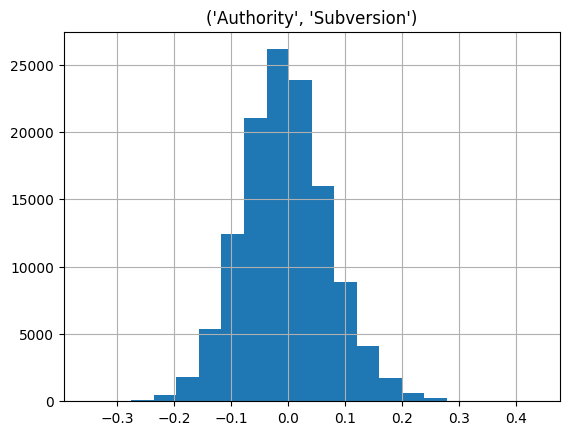

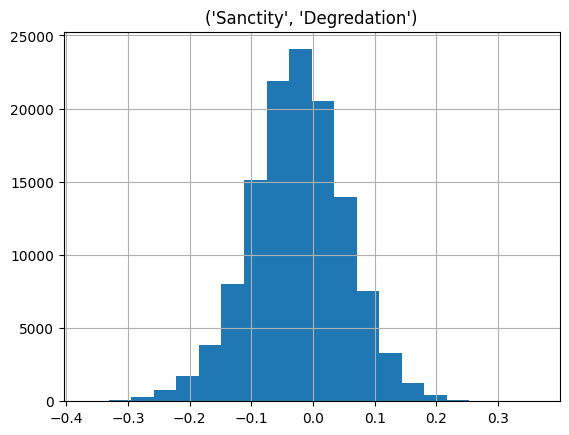

In [6]:
# todo mean + std in title
for col in df.columns:
    df.hist(column=col, bins=20)

In [7]:
sample_row = df.iloc[0]
print(f"Sample Row:\n{sample_row}\n")

print("Empirical Percentiles")
percentiles = calculate_percentile_empirically(prepare_and_sort_data(df), sample_row)
for i, (col, percentile) in enumerate(zip(df.columns, percentiles)):
    print(f"\t{col}: {round(percentile, 2)}")

print("\nNormal Distribution Percentiles")
percentiles = calculate_percentile_normal(sample_row, means, stds)
for i, (col, percentile) in enumerate(zip(df.columns, percentiles)):
    print(f"\t{col}: {round(percentile, 2)}")


Sample Row:
Care       Harm          -0.002810
Fairness   Cheating       0.146377
Loyalty    Betrayal       0.064997
Authority  Subversion     0.080494
Sanctity   Degredation    0.080338
Name: 0, dtype: float64

Empirical Percentiles
	('Care', 'Harm'): 44.16
	('Fairness', 'Cheating'): 95.57
	('Loyalty', 'Betrayal'): 77.11
	('Authority', 'Subversion'): 87.16
	('Sanctity', 'Degredation'): 91.81
Normal Distribution Percentiles
	('Care', 'Harm'): 46.47
	('Fairness', 'Cheating'): 95.7
	('Loyalty', 'Betrayal'): 76.42
	('Authority', 'Subversion'): 86.79
	('Sanctity', 'Degredation'): 91.42
